In [4]:
import seaborn as sns 
import numpy as np
import pandas as pd 
import pathlib
import json 
from matplotlib import pyplot as plt 
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 18, 'lines.markeredgewidth': 5})
# sns.set_style(style='ticks')

In [95]:
name_lookup = {"valid_em": "Exact Match", "valid_coarse": "Coarse", "valid_fine": "Fine", "valid_precision": "Precision", 
               "test_em": "Exact Match", "test_coarse": "Coarse", "test_fine": "Fine", "test_precision": "Precision"}
def plot_calflow(datas, title, savepath=None, fixed_axis=False, prefix="valid", 
        xs = ["5000","10000","20000","50000","100000","max"], 
        ax = None, use_total=True, use_coarse=False, add_nums=False, ymin = None, ymax=None,
        legend_kws={}):


    all_data = {}
    for i, (fxn, data) in enumerate(datas):
        col_names = ['train', fxn]
        if use_total or i == 0:
            col_names.append("Total")
        if use_coarse:
            col_names.append(f"{prefix}_coarse")

        data['train'] = data['train'].astype(str)
        data = data.rename(columns={"train": "train", "function": "function", "seed": "seed", "test_coarse": "test_coarse", f"{prefix}_em": f"Total", f"{prefix}_fine": fxn} )
        minor_data = data[col_names]
        minor_data = pd.melt(minor_data, id_vars=['train'])
        all_data[fxn] = minor_data
    big_data = pd.concat(all_data.values(), ignore_index=True)
    # sns.set_style(style='ticks')
    # sns.set_theme(font_scale = 1.1, style="ticks", context = "paper") 
    if ax is None:
        fig, ax = plt.subplots()

    sns.set_theme(font_scale = 1.1, style="ticks", context = "paper") 
    sns.lineplot(data=big_data, 
                x="train", 
                y="value",  
                hue="variable", 
                err_style="band", 
                # err_kws={"capsize":7, "markeredgewidth":2,  "elinewidth":2}, 
                # marker = "o", 
                markersize=7,
                linewidth=3,
                ax=ax)
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    sns.set_theme(font_scale = 1.1, style="ticks", context = "paper") 

    if add_nums:
        for i, num in enumerate(xs):
            for var in [f'{prefix}_em', f'{prefix}_coarse', f'{prefix}_fine']:
                data_subset = minor_data[minor_data['train'] == str(num)] 
                data_subset = data_subset[data_subset['variable'] == var]
                mean_value = data_subset.mean()['value']
                ax.annotate(f"{mean_value:.2f}", (i, mean_value))

    if fixed_axis:
        ax.ylim(20, 100)
    if ymin is not None:
        ax.set_ylim(bottom=ymin)
    if ymax is not None:
        ax.set_ylim(top=ymax)
    # sns.set(font_scale = 1.1)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel("Total Training Examples")
    # try:
    #     legend = ax.get_legend()
    #     handles, labels = legend.legendHandles, legend.texts

    #     text_labels = []
    #     for i, text in enumerate(labels):
    #         text_labels.append(name_lookup[text._text])

    #     ax.legend(handles, text_labels)
    # except AttributeError:
    #     pass

    ax.legend(**legend_kws)


    # sns.set(font_scale = 1.1)

    if savepath is not None:
        plt.tight_layout()
        plt.savefig(savepath)



In [96]:


def get_data_from_dir(root_data_dir, fxn, seeds):
    all_data = pd.DataFrame(columns=["train", "function", "seed", "total_acc", f"{fxn}_acc", "intent"], dtype=object)
    root_data_dir = pathlib.Path(root_data_dir).joinpath(str(fxn))
    for seed in seeds:
        data_dir = root_data_dir.joinpath(f"{seed}_seed")

        globs = [x for x in data_dir.glob("*/test_metrics.json")]
        globs = sorted(globs, key = lambda x: int(x.parent.name.split("_")[0]))

        for path in globs:
            try:
                data = json.load(open(path))
            except json.JSONDecodeError:
                data = {}
                data['acc'] = np.nan
                data[f'{fxn}_acc'] = np.nan

            setting = path.parent.name
            num_train, num_fxn = setting.split("_")
            num_train, num_fxn = int(num_train), int(num_fxn)

            to_add = {"train": str(num_train), "function": num_fxn, "seed": seed, 
                     "total_acc": data['acc'] * 100, "intent": fxn, f"{fxn}_acc": data[f"{fxn}_acc"] * 100}
            all_data = all_data.append(to_add, ignore_index=True)

    return all_data 

name_mapping = {"50": "play_radio", "66": "traffic", "15": "email_query"}
def plot_intent(data_dirs, 
                seeds = [12, 31, 64], 
                title=None, 
                savepath=None, 
                fixed_axis=False, 
                xs = [750, 1500, 3000, 7500, 15000, 18000], 
                ax = None, 
                fxn_split = 15,
                axis_title = None,
                legend_kws = {}):
    all_data = {}

    for i, (intent, data_dir) in enumerate(data_dirs):
        data = get_data_from_dir(data_dir, intent, seeds)
        data = data[data['function'] == fxn_split]
        if i == 0:
            col_names = ["train", "total_acc", f"{intent}_acc"]
        else:
            col_names = ["train", f"{intent}_acc"]

        minor_data = data[col_names]
        minor_data = minor_data.rename(columns={"train": "train", 
                                        "total_acc": "Total", 
                                        f"{intent}_acc": name_mapping[str(intent)]})
        minor_data = pd.melt(minor_data, id_vars=['train'])
        all_data[intent] = minor_data

    if ax is None:
        fig, ax = plt.subplots()

    big_data = pd.concat(all_data.values(), ignore_index=True) 

    sns.set_theme(font_scale = 1.1, style="ticks", context = "paper") 
    sns.lineplot(data=big_data, 
                x="train", 
                y="value",  
                hue="variable", 
                err_style="band", 
                # err_kws={"capsize":7, "markeredgewidth":2,  "elinewidth":2}, 
                # marker = "o", 
                markersize=7,
                linewidth=3,
                ax=ax)
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    sns.set_theme(font_scale = 1.1, style="ticks", context = "paper") 

    # for i, num in enumerate(xs):
    #     for var in ['total_acc', 'fxn_acc']:
    # #     for var in [f'{prefix}_em', f'{prefix}_coarse', f'{prefix}_fine']:
    #         data_subset = minor_data[minor_data['train'] == str(num)] 
    #         data_subset = data_subset[data_subset['variable'] == var]
    #         mean_value = data_subset.mean()['value']
    #         ax.annotate(f"{mean_value:.2f}", (i, mean_value))

    # if fixed_axis:
    #     ax.ylim(20, 100)

    # # sns.set(font_scale = 1.1)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel("")

    if axis_title is not None:
        ax.set_xlabel("Total Training Examples")
    else:
        ax.set_xlabel("") 

    ax.legend(**legend_kws)

    # sns.set(font_scale = 1.1)

    if savepath is not None:
        plt.tight_layout()
        plt.savefig(savepath)




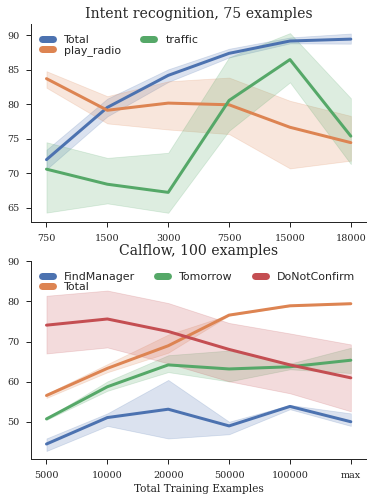

In [98]:
# Figure 1: showing decreasing accuracy for both intent and calflow 
from matplotlib.legend_handler import HandlerLine2D

plt.rcParams.update({'font.size': 24, 'lines.markeredgewidth': 5, 'font.family': "DejaVu Serif"})


def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(7)

handler_map={plt.Line2D : HandlerLine2D(update_func=update)}

fig, ax = plt.subplots(2, 1, sharex=False, sharey=False, figsize = (6, 8))

plot_intent([(50, "/brtx/603-nvme1/estengel/intent/"),
             (66, "/brtx/603-nvme1/estengel/intent/"), 
             (15, "/brtx/606-nvme1/estengel/intent/")], [12, 31, 64],
              title = f"Intent recognition, 75 examples", fxn_split=75, ax=ax[0],
              axis_title=None,
              legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
                              handletextpad=1.0, handler_map=handler_map))

fm_data = pd.read_csv("~/papers/incremental_function_learning/results/FindManager_transformer_test.csv", index_col=0)
tomorrow_data = pd.read_csv("~/papers/incremental_function_learning/results/Tomorrow_transformer_test.csv", index_col=0)
donotconfirm_data = pd.read_csv("~/papers/incremental_function_learning/results/DoNotConfirm_transformer_full_test.csv", index_col=0)

datas = [("FindManager", fm_data), ("Tomorrow", tomorrow_data), ("DoNotConfirm", donotconfirm_data)]
plot_calflow(datas, 
            title = "Calflow, 100 examples", 
            prefix="test", 
            ax=ax[1], 
            use_coarse=False, 
            use_total=False,
            ymin=None,
            ymax=90,
            legend_kws=dict(ncol=3, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
                              handletextpad=1.0, handler_map=handler_map)
            )

